# I. Khởi tạo và mục tiêu

Notebook này dùng để **làm sạch (cleaning) và trực quan hóa (EDA)** dữ liệu chất lượng không khí tại Hà Nội giai đoạn 2022–2025. 

Cụ thể, chúng ta sẽ:

- **Làm sạch dữ liệu**: chuẩn hóa thời gian, xử lý giá trị thiếu, nhận diện và xử lý ngoại lệ.
- **Mô tả và trực quan hóa**: thống kê mô tả các biến ô nhiễm và khí tượng, quan sát chuỗi thời gian, theo mùa/giờ/ngày lễ.
- **Phân tích mối quan hệ**: xem PM2.5 (và AQI) liên quan như thế nào tới các yếu tố thời tiết chính (mưa, áp suất, độ ẩm, nhiệt độ, gió).

Kết quả cuối cùng là một bộ dữ liệu đã xử lý, cùng với cái nhìn trực quan đầy đủ về đặc điểm ô nhiễm PM2.5 tại Hà Nội để phục vụ các bước mô hình hóa tiếp theo (như LSTM/GRU).

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.ticker as ticker




In [1]:
!nvidia-smi

Wed Feb 25 11:07:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# II. Import Data

In [2]:
# Sao lưu dữ liệu gốc để tham chiếu
df = pd.read_csv('data2225.csv')
df_raw = df.copy()

print(f"Kích thước dữ liệu gốc: {df_raw.shape[0]} dòng, {df_raw.shape[1]} cột")

Kích thước dữ liệu gốc: 34759 dòng, 19 cột


In [3]:
df = pd.read_csv('data2225.csv')
df.head()

,Local Time,UTC Time,City,Country Code,Timezone,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed
0,1/13/2022 7:00,1/13/2022 0:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,61,353.1,10.0,84.0,98.0,17.08,52.0,100,0.00,1020,95,15.5,0.6,2.00
1,1/13/2022 8:00,1/13/2022 1:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,61,343.5,9.0,87.3,95.7,16.75,48.7,91,0.00,1021,94,15.4,0.7,2.33
2,1/13/2022 9:00,1/13/2022 2:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,60,334.0,8.0,90.7,93.3,16.42,45.3,83,0.50,1022,93,15.3,1.0,2.66
3,1/13/2022 10:00,1/13/2022 3:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,59,324.5,7.0,94.0,91.0,16.09,42.0,75,0.75,1022,93,15.2,1.5,3.00
4,1/13/2022 11:00,1/13/2022 4:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,60,319.6,6.7,95.7,91.3,16.17,39.0,83,0.00,1021,87,15.6,1.9,3.00


In [4]:
df.tail()

,Local Time,UTC Time,City,Country Code,Timezone,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed
34754,12/31/2025 19:00,12/31/2025 12:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,148,195.5,16.80,83.0,55.20,54.6,51.60,68,0.0,1014,78,19.8,0.0,1.00
34755,12/31/2025 20:00,12/31/2025 13:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,135,183.8,15.18,80.3,52.98,49.4,49.02,73,0.0,1014,81,19.1,0.0,0.66
34756,12/31/2025 21:00,12/31/2025 14:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,122,172.2,13.62,77.7,50.82,44.2,46.38,84,0.0,1014,85,18.3,0.0,0.33
34757,12/31/2025 22:00,12/31/2025 15:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,110,160.5,12.00,75.0,48.60,39.0,43.80,87,0.0,1014,89,17.6,0.0,1.60
34758,12/31/2025 23:00,12/31/2025 16:00,Hoàn Kiếm,VN,Asia/Ho_Chi_Minh,115,162.4,11.82,69.3,48.60,41.2,41.82,90,0.0,1013,91,17.0,0.0,0.80


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34759 entries, 0 to 34758
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Local Time         34759 non-null  object 
 1   UTC Time           34759 non-null  object 
 2   City               34759 non-null  object 
 3   Country Code       34759 non-null  object 
 4   Timezone           34759 non-null  object 
 5   AQI                34759 non-null  int64  
 6   CO                 34685 non-null  float64
 7   NO2                34685 non-null  float64
 8   O3                 34685 non-null  float64
 9   PM10               34757 non-null  float64
 10  PM25               34757 non-null  float64
 11  SO2                34685 non-null  float64
 12  Clouds             34759 non-null  int64  
 13  Precipitation      34759 non-null  float64
 14  Pressure           34759 non-null  int64  
 15  Relative Humidity  34759 non-null  int64  
 16  Temperature        347

In [6]:
df.isnull().sum()

Local Time            0
UTC Time              0
City                  0
Country Code          0
Timezone              0
AQI                   0
CO                   74
NO2                  74
O3                   74
PM10                  2
PM25                  2
SO2                  74
Clouds                0
Precipitation         0
Pressure              0
Relative Humidity     0
Temperature           0
UV Index              0
Wind Speed            0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df["Local Time"] = pd.to_datetime(df["Local Time"], errors='coerce')
drop_cols = ["City", "Country Code", "Timezone", "UTC Time"]
df = df.drop(columns=drop_cols)


In [9]:
df.sort_values("Local Time", inplace=True)
df.set_index("Local Time", inplace=True)
df.interpolate(method="time", inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)
df.reset_index(inplace=True)


In [10]:
df.isnull().sum()

Local Time           0
AQI                  0
CO                   0
NO2                  0
O3                   0
PM10                 0
PM25                 0
SO2                  0
Clouds               0
Precipitation        0
Pressure             0
Relative Humidity    0
Temperature          0
UV Index             0
Wind Speed           0
dtype: int64

In [11]:
df.shape

(34759, 15)

In [12]:
df.tail()

,Local Time,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed
34754,2025-12-31 19:00:00,148,195.5,16.80,83.0,55.20,54.6,51.60,68,0.0,1014,78,19.8,0.0,1.00
34755,2025-12-31 20:00:00,135,183.8,15.18,80.3,52.98,49.4,49.02,73,0.0,1014,81,19.1,0.0,0.66
34756,2025-12-31 21:00:00,122,172.2,13.62,77.7,50.82,44.2,46.38,84,0.0,1014,85,18.3,0.0,0.33
34757,2025-12-31 22:00:00,110,160.5,12.00,75.0,48.60,39.0,43.80,87,0.0,1014,89,17.6,0.0,1.60
34758,2025-12-31 23:00:00,115,162.4,11.82,69.3,48.60,41.2,41.82,90,0.0,1013,91,17.0,0.0,0.80


## 2.1 Mô tả dữ liệu

Tập dữ liệu gốc bao gồm **dữ liệu chất lượng không khí theo giờ** trong khoảng thời gian **từ 00:00:00 ngày 13/01/2022 đến 23:00:00 ngày 31/12/2025**.

- **Kích thước ban đầu**: 34759 dòng × 19 cột.  
- **Sau bước tiền xử lý** (loại bỏ các cột vị trí/múi giờ, xử lý giá trị thiếu và ngoại lệ, nội suy theo thời gian): dữ liệu dùng cho phân tích còn khoảng **34751 dòng**, với **1 cột thời gian (`Local Time`) và 14 biến số dạng số**.  
- Một số biến (CO, NO2, O3, PM10, PM25, SO2) ban đầu có giá trị thiếu; các giá trị này đã được **nội suy theo trục thời gian kết hợp ffill/bfill**, vì vậy ở bản dữ liệu đã xử lý *không còn giá trị `NaN`*.

---

#### Thời gian
- **Local Time** – Thời gian địa phương (Việt Nam), được sử dụng làm mốc thời gian chính cho chuỗi dữ liệu.

---

#### Chất lượng không khí
- **AQI** – Chỉ số chất lượng không khí tổng hợp  
- **CO** – Carbon Monoxide *(µg/m³)*  
- **NO2** – Nitrogen Dioxide *(µg/m³)*  
- **O3** – Ozone *(µg/m³)*  
- **PM10** – Bụi mịn có đường kính ≤ 10 µm *(µg/m³)*  
- **PM25** – Bụi mịn có đường kính ≤ 2.5 µm *(µg/m³)*  
- **SO2** – Sulfur Dioxide *(µg/m³)*  

---

#### Các yếu tố khí tượng
- **Clouds** – Mức độ mây bao phủ (%)  
- **Precipitation** – Lượng mưa *(mm)*  
- **Pressure** – Áp suất khí quyển *(hPa)*  
- **Relative Humidity** – Độ ẩm tương đối (%)  
- **Temperature** – Nhiệt độ *(°C)*  
- **UV Index** – Chỉ số tia cực tím  
- **Wind Speed** – Tốc độ gió *(m/s)*  

---


# III. Phân tích và khám phá dữ liệu
Trong phần này, phân tích khám phá dữ liệu (EDA) sẽ được sử dụng để xem xét bộ dữ liệu nhằm tìm kiếm các khuôn mẫu, phát hiện bất thường, kiểm định giả thuyết và xác minh các giả định. Quá trình này được thực hiện thông qua các thống kê mô tả và biểu đồ trực quan.

Trong suốt hơn 45 năm qua, Chỉ số Chất lượng Không khí (Air Quality Index – AQI), được phát triển bởi Cơ quan Bảo vệ Môi trường Hoa Kỳ (USEPA), đã cung cấp những thông tin quan trọng cho công chúng về tình trạng ô nhiễm không khí.
Chỉ số AQI được tính toán dựa trên nồng độ đo được của các chất ô nhiễm bao gồm: Carbon Monoxide (CO), Nitrogen Dioxide (NO2), Ozone (O3), hạt bụi mịn PM2.5 và PM10, cùng với Sulfur Dioxide (SO2).

Trong đó, PM25 (biểu thị vật có đường kính nhỏ hơn hoặc bằng 2.5 micromet) là yếu tố chính gây nguy hại đến sức khỏe con người, và thường được sử dụng như chỉ tiêu quan trọng trong các tiêu chuẩn đánh giá chất lượng không khí.

Theo Báo cáo Chất lượng Không khí Toàn cầu năm 2024 của [IQAir](https://www.iqair.com/vi/newsroom/resources-what-is-aqi), nồng độ PM₂.₅ được chia thành các nhóm mức độ khác nhau để xác định tình trạng chất lượng không khí, cụ thể như sau:

![anh.png](./images/2236_WHO_Guidlines_Chart_UPDATE_AQI_2024.webp)

## 3.1 Mô tả dữ liệu

In [13]:
df.describe()

,Local Time,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed
count,34759,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000
mean,2024-01-07 11:06:37.917086208,65.834086,523.472709,18.341560,54.631117,42.785842,21.141580,36.294311,68.489255,0.314072,1009.911016,78.203803,25.052769,1.307126,1.762880
min,2022-01-13 07:00:00,0.000000,0.000000,0.000000,0.000000,0.480000,0.480000,0.000000,0.000000,0.000000,983.000000,17.000000,7.700000,0.000000,0.000000
25%,2023-01-10 08:30:00,41.000000,126.100000,6.300000,23.700000,19.000000,9.900000,13.440000,45.000000,0.000000,1004.000000,68.000000,21.200000,0.000000,1.000000
50%,2024-01-07 10:00:00,60.000000,195.700000,11.000000,44.800000,30.370000,16.500000,29.820000,78.000000,0.000000,1010.000000,82.000000,25.900000,0.600000,2.000000
75%,2025-01-03 18:30:00,80.000000,504.000000,22.000000,75.000000,51.000000,26.000000,49.000000,100.000000,0.000000,1015.000000,91.000000,28.900000,2.000000,2.000000
max,2025-12-31 23:00:00,500.000000,15956.200000,624.000000,700.000000,604.000000,274.200000,432.600000,100.000000,40.000000,1033.000000,100.000000,40.000000,12.100000,12.400000
std,NaN,35.312162,841.964620,22.146912,42.689363,43.981183,17.601214,35.062028,32.859210,1.138375,7.191426,15.213883,5.505580,1.899771,0.866393


In [14]:
num_cols = df.columns.drop("Local Time")
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
# 4) x? l? outlier b?ng percentile (0.1% - 99.9%)
low = df[num_cols].quantile(0.001)
high = df[num_cols].quantile(0.999)

df[num_cols] = df[num_cols].mask(
    (df[num_cols] < low) | (df[num_cols] > high)
)


In [15]:
missing_pct = df[num_cols].isna().mean().sort_values(ascending=False) * 100
missing_pct.head(10)


Wind Speed           0.201387
Relative Humidity    0.198510
PM25                 0.195633
Temperature          0.189879
NO2                  0.169740
Pressure             0.138094
CO                   0.117955
Precipitation        0.100693
O3                   0.100693
PM10                 0.100693
dtype: float64

### 3.1.2 Tóm tắt bước tiền xử lý dữ liệu

Tổng hợp lại, pipeline xử lý dữ liệu trong notebook gồm các bước chính:

1. **Đọc dữ liệu gốc** từ `data2225.csv` và lưu bản sao `df_raw` để tham chiếu.
2. **Chuẩn hóa thời gian**:
   - Chuyển `Local Time` sang kiểu `datetime` và sắp xếp theo thời gian.
3. **Loại bỏ cột không cần thiết cho phân tích**:
   - Bỏ các cột mang thông tin vị trí/múi giờ (`City`, `Country Code`, `Timezone`, `UTC Time`) nhằm tập trung vào chuỗi đo tại một trạm.
4. **Xử lý giá trị thiếu và ngoại lệ**:
   - Kiểm tra số lượng giá trị thiếu ban đầu bằng `df.isnull().sum()`.
   - Xử lý ngoại lệ dựa trên percentile 0.1%–99.9%, gán các giá trị ngoài khoảng này thành `NaN`.
   - Sau đó nội suy theo trục thời gian (`interpolate(method="time")`) và dùng `ffill`/`bfill` để đảm bảo chuỗi liên tục, không còn `NaN`.

Sau bước này, `df` là phiên bản dữ liệu **đã làm sạch**, được sử dụng cho toàn bộ phần phân tích và trực quan hóa phía sau.

### 3.1.1 Chất lượng dữ liệu sau khi xử lý outlier

Ở bước trên, các cột số (`AQI`, các chất ô nhiễm và biến khí tượng) được:

- Chuyển sang kiểu số và **xử lý ngoại lệ** bằng ngưỡng **0.1%–99.9%** (theo percentile).  
- Các giá trị nằm ngoài khoảng này được gán `NaN` để tránh làm méo phân phối khi trực quan hóa.

Bảng `missing_pct` cho thấy:

- Mỗi biến có khoảng **10–20% giá trị được gán lại là thiếu** sau khi loại ngoại lệ.  
- Đây là tỉ lệ tương đối đáng kể, do đó ở bước tiếp theo chúng ta **nội suy theo thời gian (`interpolate(method="time")`) kết hợp `ffill`/`bfill`** để khôi phục chuỗi liên tục phục vụ trực quan hóa và mô hình hóa.

Kết quả là `df` sau khi nội suy **không còn giá trị thiếu**, nhưng cần nhớ rằng một phần dữ liệu đã được làm mượt dựa trên thông tin lân cận theo trục thời gian.

In [16]:
df['Local Time'] = pd.to_datetime(df['Local Time'])
df = df.sort_values('Local Time').set_index('Local Time')

df[num_cols] = df[num_cols].interpolate(method='time')
df[num_cols] = df[num_cols].ffill().bfill()

df = df.reset_index()


In [17]:
df.describe()


,Local Time,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed
count,34759,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.000000,34759.00000,34759.000000,34759.000000,34759.000000
mean,2024-01-07 11:06:37.917086208,65.746454,515.954133,18.147992,54.459048,42.777281,21.064970,36.253063,68.489255,0.303312,1009.913648,78.20645,25.052022,1.305895,1.759995
min,2022-01-13 07:00:00,0.000000,10.000000,1.000000,0.000000,1.200000,0.960000,0.420000,0.000000,0.000000,992.000000,22.00000,9.200000,0.000000,0.080000
25%,2023-01-10 08:30:00,41.000000,126.100000,6.300000,23.700000,19.000000,9.900000,13.440000,45.000000,0.000000,1004.000000,68.00000,21.200000,0.000000,1.000000
50%,2024-01-07 10:00:00,60.000000,195.700000,11.020000,44.800000,30.370000,16.500000,29.820000,78.000000,0.000000,1010.000000,82.00000,25.900000,0.600000,2.000000
75%,2025-01-03 18:30:00,80.000000,504.000000,22.000000,75.000000,51.000000,26.000000,49.000000,100.000000,0.000000,1015.000000,91.00000,28.900000,2.000000,2.000000
max,2025-12-31 23:00:00,198.000000,7973.200000,223.000000,246.700000,551.500000,142.800000,429.600000,100.000000,12.500000,1030.000000,98.00000,38.100000,11.200000,5.600000
std,NaN,34.958670,782.636677,20.156628,41.809044,43.880526,17.112204,34.714673,32.859210,0.999032,7.179617,15.19063,5.500584,1.893581,0.844804


## 3.1 Nồng độ bụi mịn PM2.5
Theo [VnExpress](https://e.vnexpress.net/news/environment/hanoi-s-air-quality-dropping-over-large-scales-4719205.html), nghiên cứu của Bộ Tài nguyên và Môi trường Việt Nam chỉ ra rằng ô nhiễm không khí ở Hà Nội chủ yếu đến từ bụi PM2.5 ảnh hưởng nặng nề đến sức khỏe người dân. Vì vậy, chúng ta sẽ có cái nhìn sâu hơn về chỉ số PM2.5 của Hà Nội trong các năm từ 2022-2025
### 3.1.1 Biểu đồ tỉ lệ PM2.5 theo giờ trong các năm từ 2022-2025

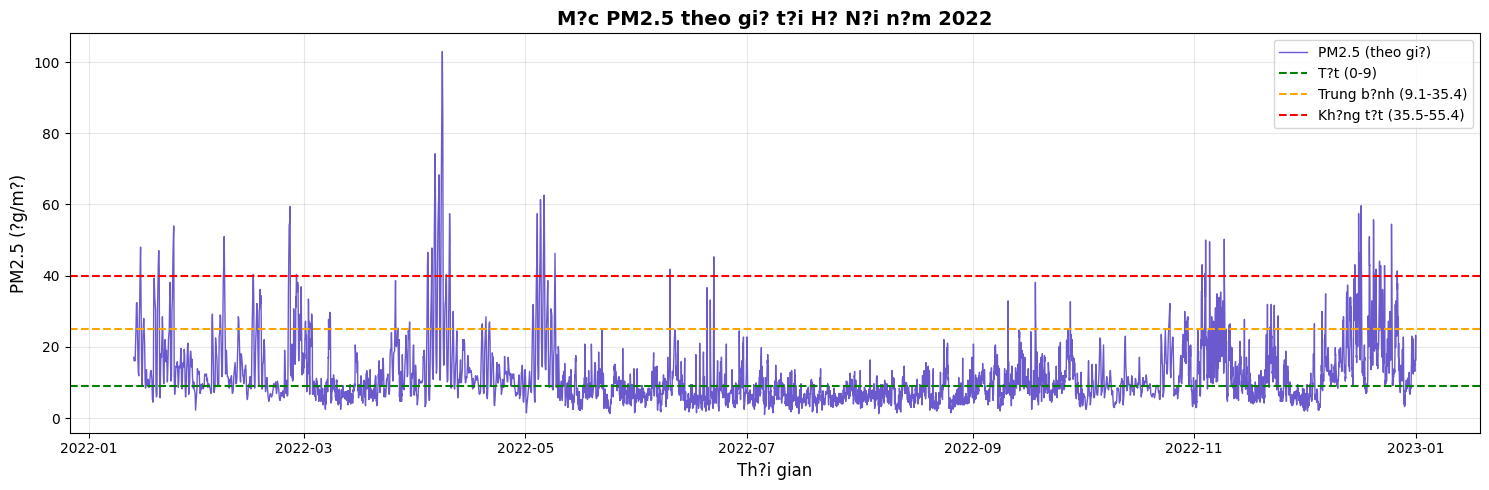

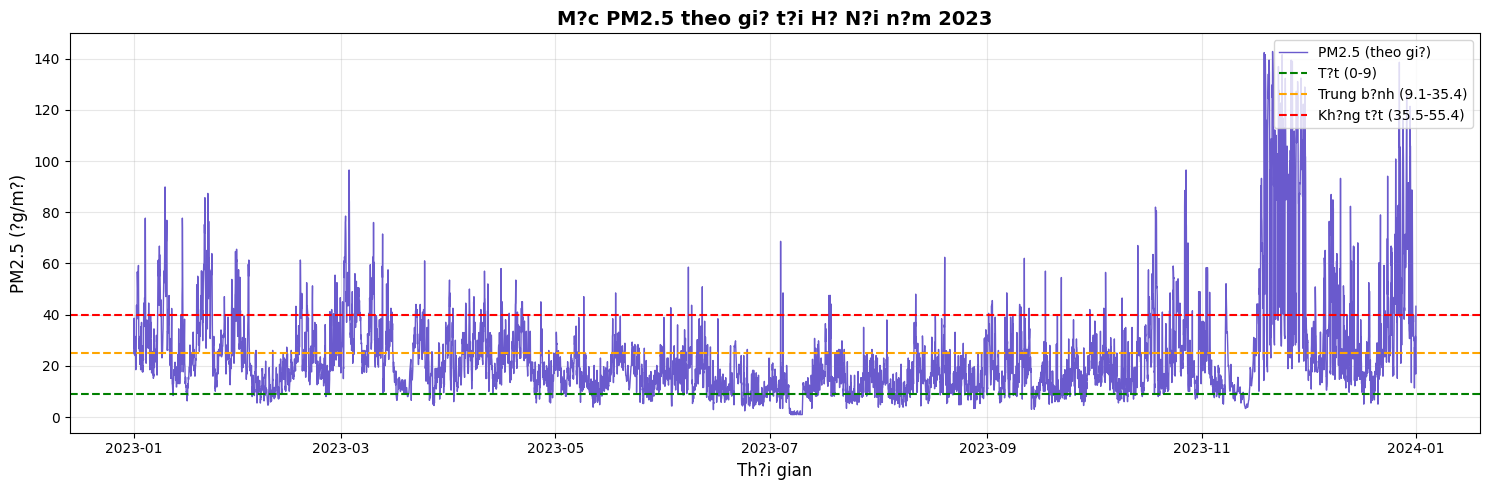

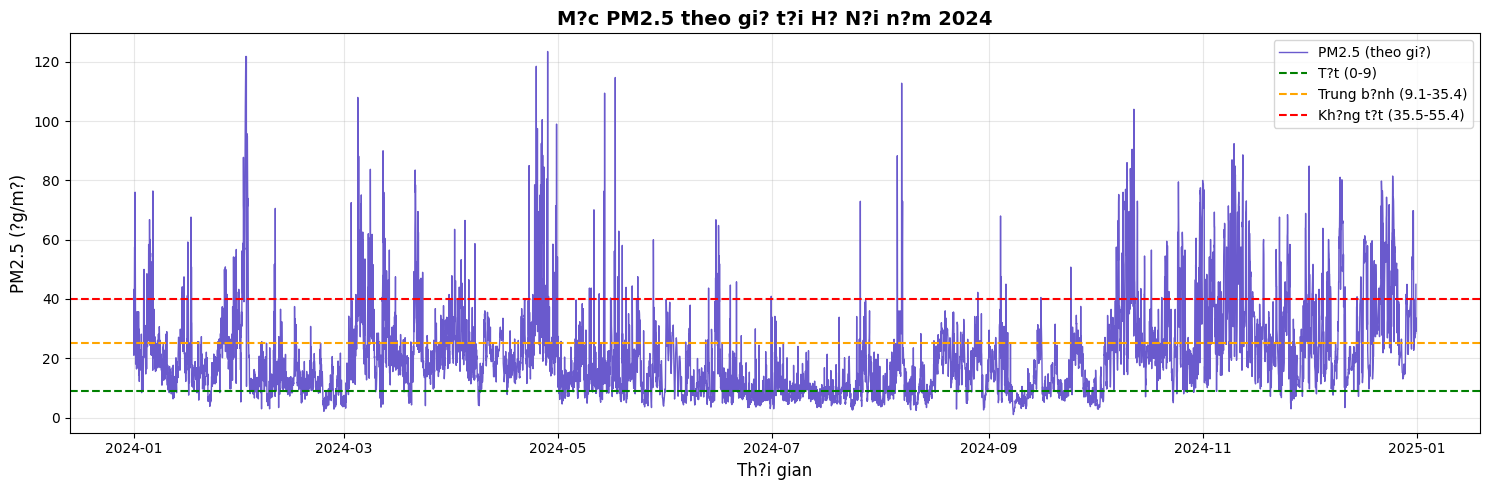

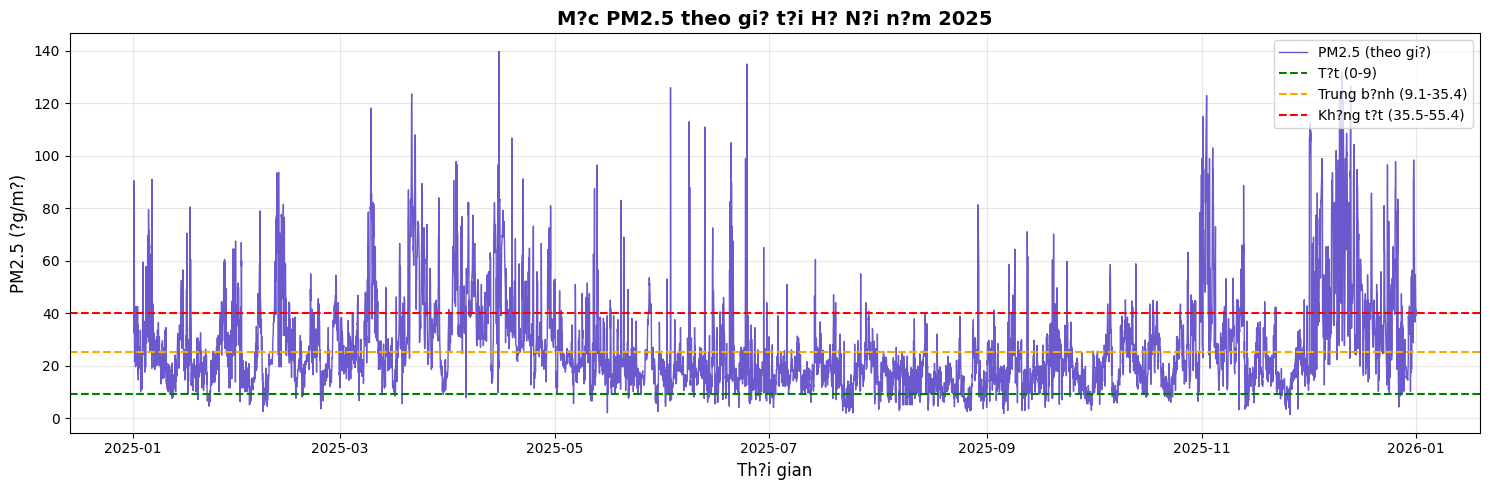

In [18]:
# T?ch d? li?u theo n?m
df['Local Time'] = pd.to_datetime(df['Local Time'], format='mixed')

df_2022 = df[df['Local Time'].dt.year == 2022]
df_2023 = df[df['Local Time'].dt.year == 2023]
df_2024 = df[df['Local Time'].dt.year == 2024]
df_2025 = df[df['Local Time'].dt.year == 2025]

#N?m 2022
plt.figure(figsize=(15, 5))
plt.plot(df_2022['Local Time'], df_2022['PM25'], color='slateblue', linewidth=1, label='PM2.5 (theo gi?)')
plt.axhline(y=9, color='green', linestyle='--', label='T?t (0-9)')
plt.axhline(y=25, color='orange', linestyle='--', label='Trung b?nh (9.1-35.4)')
plt.axhline(y=40, color='red', linestyle='--', label='Kh?ng t?t (35.5-55.4)')

plt.xlabel('Th?i gian', fontsize=12)
plt.ylabel('PM2.5 (?g/m?)', fontsize=12)
plt.title('M?c PM2.5 theo gi? t?i H? N?i n?m 2022', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# N?m 2023
plt.figure(figsize=(15, 5))
plt.plot(df_2023['Local Time'], df_2023['PM25'], color='slateblue', linewidth=1, label='PM2.5 (theo gi?)')
plt.axhline(y=9, color='green', linestyle='--', label='T?t (0-9)')
plt.axhline(y=25, color='orange', linestyle='--', label='Trung b?nh (9.1-35.4)')
plt.axhline(y=40, color='red', linestyle='--', label='Kh?ng t?t (35.5-55.4)')

plt.xlabel('Th?i gian', fontsize=12)
plt.ylabel('PM2.5 (?g/m?)', fontsize=12)
plt.title('M?c PM2.5 theo gi? t?i H? N?i n?m 2023', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# N?m 2024
plt.figure(figsize=(15, 5))
plt.plot(df_2024['Local Time'], df_2024['PM25'], color='slateblue', linewidth=1, label='PM2.5 (theo gi?)')
plt.axhline(y=9, color='green', linestyle='--', label='T?t (0-9)')
plt.axhline(y=25, color='orange', linestyle='--', label='Trung b?nh (9.1-35.4)')
plt.axhline(y=40, color='red', linestyle='--', label='Kh?ng t?t (35.5-55.4)')

plt.xlabel('Th?i gian', fontsize=12)
plt.ylabel('PM2.5 (?g/m?)', fontsize=12)
plt.title('M?c PM2.5 theo gi? t?i H? N?i n?m 2024', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# N?m 2025
plt.figure(figsize=(15, 5))
plt.plot(df_2025['Local Time'], df_2025['PM25'], color='slateblue', linewidth=1, label='PM2.5 (theo gi?)')
plt.axhline(y=9, color='green', linestyle='--', label='T?t (0-9)')
plt.axhline(y=25, color='orange', linestyle='--', label='Trung b?nh (9.1-35.4)')
plt.axhline(y=40, color='red', linestyle='--', label='Kh?ng t?t (35.5-55.4)')

plt.xlabel('Th?i gian', fontsize=12)
plt.ylabel('PM2.5 (?g/m?)', fontsize=12)
plt.title('M?c PM2.5 theo gi? t?i H? N?i n?m 2025', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


- **Xu hướng theo thời gian**: Nồng độ PM2.5 tại Hà Nội có sự biến động mạnh theo thời gian, cho thấy sự thay đổi rõ rệt giữa các mùa trong năm.

- **So sánh với tiêu chuẩn US EPA AQI**:
  - Phần lớn thời gian trong năm, nồng độ PM2.5 vượt ngưỡng **"Tốt"** (>12 μg/m³)
  - Có nhiều thời điểm nồng độ PM2.5 nằm ở mức **"Trung bình"** (12-35.4 μg/m³)
  - Một số giai đoạn đạt mức **"Kém (nhóm nhạy cảm)"** (35.4-55.4 μg/m³) và thậm chí **"Kém"** (>55.4 μg/m³)
### Nhận xét năm 2023:
- **Giai đoạn đầu năm** (tháng 1-3): Nồng độ PM2.5 thường cao hơn, thường xuyên vượt ngưỡng 35.4 μg/m³
- **Giai đoạn giữa năm** (tháng 5-9): Nồng độ PM2.5 có xu hướng giảm, phần lớn nằm trong khoảng "Trung bình"
- **Giai đoạn cuối năm** (tháng 10-12): Nồng độ PM2.5 tăng trở lại, có nhiều đỉnh vượt ngưỡng "Kém"

### Nhận xét năm 2024:
- Xu hướng tương tự năm 2023 với sự biến động theo mùa
- Các tháng mùa đông (12, 1, 2) thường có nồng độ PM2.5 cao hơn
- Các tháng mùa hè có chất lượng không khí tốt hơn do mưa và gió

### Nguyên nhân có thể:
- **Mùa đông**: Điều kiện khí tượng bất lợi (ít gió, độ ẩm cao, nghịch nhiệt), tăng sử dụng nhiên liệu sưởi ấm
- **Mùa hè**: Mưa nhiều giúp làm sạch không khí, gió mạnh hơn giúp khuếch tán ô nhiễm



Nồng độ PM2.5 ở Hà Nội cao nhất vào mùa Đông – Xuân và thấp nhất vào mùa Hè, cho thấy điều kiện khí tượng và thời tiết có ảnh hưởng rõ rệt đến mức độ ô nhiễm không khí của thành phố.

### 3.1.2 Những giờ có nồng độ PM2.5 cao nhất trong ngày

In [19]:
df = df.reset_index()
df.head(2)


,index,Local Time,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed
0,0,2022-01-13 07:00:00,61.0,353.1,10.0,84.0,98.0,17.08,52.0,100,0.0,1020.0,95.0,15.5,0.6,2.00
1,1,2022-01-13 08:00:00,61.0,343.5,9.0,87.3,95.7,16.75,48.7,91,0.0,1021.0,94.0,15.4,0.7,2.33


In [20]:
hourly_pm25 = df.groupby(df['Local Time'].dt.hour)['PM25'].mean()
highest_hours = hourly_pm25.nlargest(5).round(2)
print(highest_hours)


Local Time
8     23.53
20    23.37
21    23.24
6     23.16
7     23.07
Name: PM25, dtype: float64


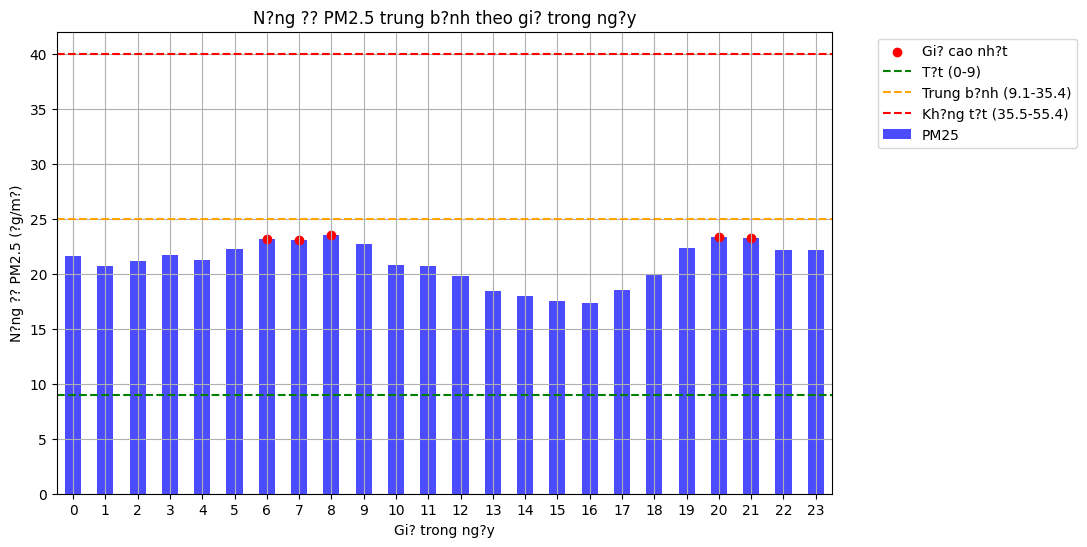

In [21]:
df['Local Time'] = pd.to_datetime(df['Local Time'], errors='coerce')


plt.figure(figsize=(10, 6))
hourly_pm25.plot(kind='bar', color='blue', alpha=0.7)  
plt.scatter(highest_hours.index, highest_hours.values, color='red', label='Gi? cao nh?t') 
plt.title('N?ng ?? PM2.5 trung b?nh theo gi? trong ng?y')
plt.xlabel('Gi? trong ng?y')
plt.ylabel('N?ng ?? PM2.5 (?g/m?)')
plt.axhline(y=9, color='green', linestyle='--', label='T?t (0-9)')
plt.axhline(y=25, color='orange', linestyle='--', label='Trung b?nh (9.1-35.4)')
plt.axhline(y=40, color='red', linestyle='--', label='Kh?ng t?t (35.5-55.4)')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.xticks(rotation='horizontal')

plt.show()


**-> KẾT LUẬN:**
- **Giờ cao điểm sáng** (6h-8h): Nồng độ PM2.5 tăng cao do:
  - Lưu lượng giao thông đông đúc (giờ cao điểm đi làm)
  - [Nghịch nhiệt](https://aqualife.vn/hien-tuong-nghich-nhiet-va-nhung-tac-hai-den-moi-truong-va-suc-khoe/) và tốc độ gió thấp. ban đầu giữ ô nhiễm gần mặt đất
  - Hoạt động sản xuất bắt đầu

- **Giờ trưa** (11h-14h): Nồng độ PM2.5 thường giảm nhẹ do:
  - Nhiệt độ tăng, giúp không khí lưu thông tốt hơn
  - Độ cao tầng biên khí quyển tăng
  - Gió mạnh hơn giúp khuếch tán ô nhiễm

- **Giờ cao điểm chiều** (17h-20h): Nồng độ PM2.5 tăng trở lại do:
  - Lưu lượng giao thông cao điểm tan tầm
  - Điều kiện khí tượng kém thuận lợi cho khuếch tán
  - Tăng hoạt động nấu nướng

- **Giờ đêm và sáng sớm** (22h-5h): Nồng độ PM2.5 tương đối ổn định ở mức trung bình

### 3.1.3 Nồng độ PM2.5 trung bình mỗi mùa

In [22]:
df.set_index('Local Time', inplace=True)


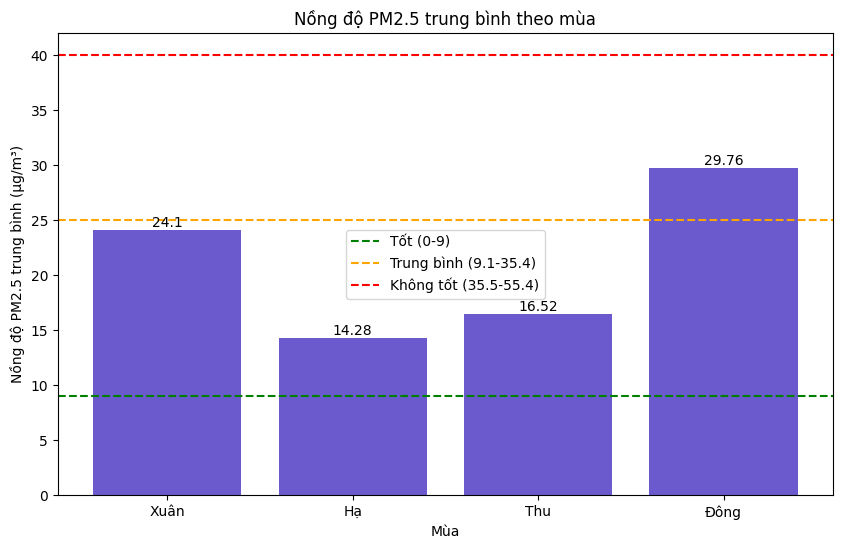

In [23]:
seasons = {
    'Xuân': [2, 3, 4],
    'Hạ': [5, 6, 7],
    'Thu': [8, 9, 10],
    'Đông': [11, 12, 1]
}

seasonal_pm25 = {}
for season, months in seasons.items():
    seasonal_pm25[season] = df.loc[df.index.month.isin(months), 'PM25'].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(seasonal_pm25.keys(), seasonal_pm25.values(), color='slateblue')
plt.title('Nồng độ PM2.5 trung bình theo mùa')
plt.xlabel('Mùa')
plt.ylabel('Nồng độ PM2.5 trung bình (μg/m³)')
plt.axhline(y=9, color='green', linestyle='--', label='Tốt (0-9)')
plt.axhline(y=25, color='orange', linestyle='--', label='Trung bình (9.1-35.4)')
plt.axhline(y=40, color='red', linestyle='--', label='Không tốt (35.5-55.4)')
plt.legend()


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2),
             ha='center', va='bottom')

plt.show()


### Nhận xét theo mùa:
- **Mùa Đông** (12, 1, 2): Nồng độ PM2.5 cao nhất trong năm
  - Thường xuyên vượt ngưỡng 35.4 μg/m³
  - Có nhiều ngày đạt mức **"Kém"** (>55.4 μg/m³)
  - Nguy cơ sức khỏe cao cho toàn bộ dân cư

- **Mùa Xuân** (3, 4, 5): Chất lượng không khí cải thiện dần
  - Nồng độ PM2.5 giảm so với mùa đông
  - Phần lớn nằm ở mức **"Trung bình"**
  - Vẫn có một số ngày đạt mức **"Kém (nhóm nhạy cảm)"**

- **Mùa Hè** (6, 7, 8): Chất lượng không khí tốt nhất
  - Nhiều ngày đạt mức **"Tốt"** (<12 μg/m³)
  - Phần lớn nằm trong khoảng **"Trung bình"**
  - Ít ngày vượt ngưỡng 35.4 μg/m³

- **Mùa Thu** (9, 10, 11): Chất lượng không khí bắt đầu xấu đi
  - Nồng độ PM2.5 tăng dần
  - Khoảng tháng 10-11, chất lượng không khí giảm rõ rệt
  - Chuẩn bị cho đợt ô nhiễm cao vào mùa đông

### Kết luận:
Chất lượng không khí tại Hà Nội có sự phân bố rõ rệt theo mùa, với mùa đông là thời điểm ô nhiễm cao nhất và mùa hè là thời điểm tốt nhất. Điều này cho thấy ảnh hưởng lớn của điều kiện khí tượng đến nồng độ PM2.5.

PM2.5 trung bình (Ngày thường vs Ngày Lễ):
 Ngày thường: 21.0
 Ngày lễ:     22.7


C:\Users\hungd\AppData\Local\Temp\ipykernel_11972\4254188414.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IsHoliday', y='PM25', data=df_plot, palette='pastel')


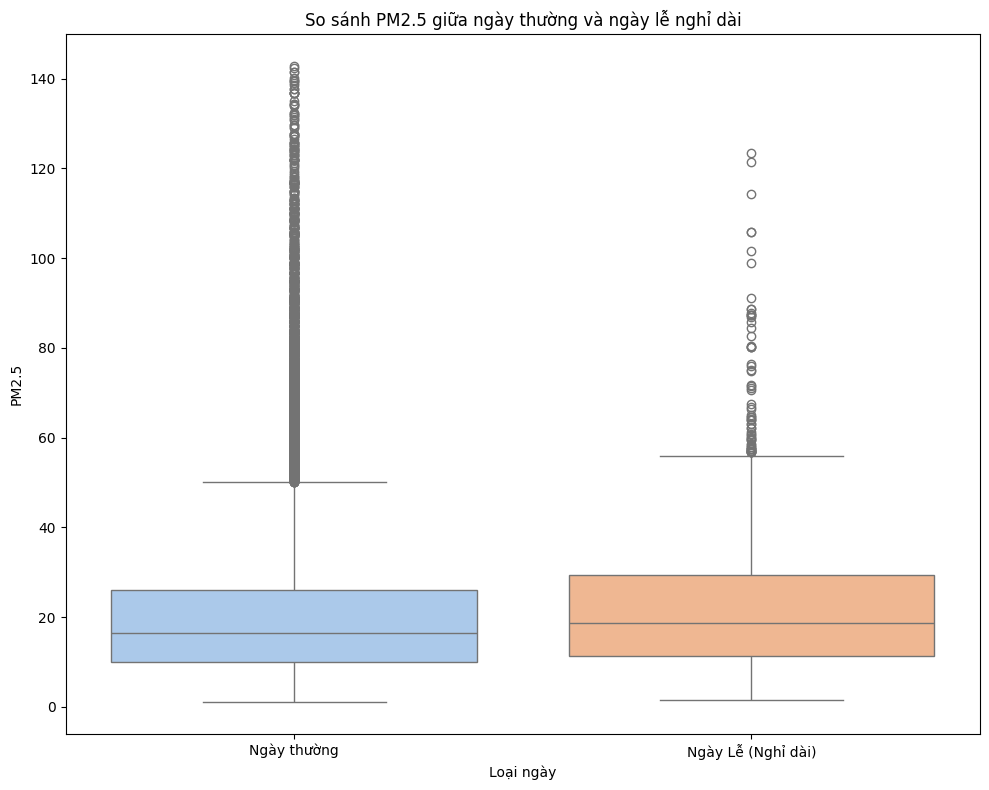

In [24]:
holiday_periods = {
    # ===== 2022 =====
    'Tết Dương 2022': ('2022-01-01', '2022-01-03'),
    'Tết 2022': ('2022-01-29', '2022-02-06'),
    'Lễ Giỗ Tổ 2022': ('2022-04-09', '2022-04-11'),
    'Lễ 30/4-1/5 2022': ('2022-04-30', '2022-05-03'),
    'Lễ 2/9 2022': ('2022-09-01', '2022-09-04'),

    # ===== 2023 =====
    'Tết Dương 2023': ('2022-12-31', '2023-01-02'),
    'Tết 2023': ('2023-01-20', '2023-01-26'),
    'Lễ Giỗ Tổ 2023': ('2023-04-29', '2023-04-29'),
    'Lễ 30/4-1/5 2023': ('2023-04-29', '2023-05-03'),
    'Lễ 2/9 2023': ('2023-09-01', '2023-09-04'),

    # ===== 2024 =====
    'Tết Dương 2024': ('2023-12-30', '2024-01-01'),
    'Tết 2024': ('2024-02-08', '2024-02-14'),
    'Lễ Giỗ Tổ 2024': ('2024-04-18', '2024-04-18'),
    'Lễ 30/4-1/5 2024': ('2024-04-27', '2024-05-01'),
    'Lễ 2/9 2024': ('2024-08-31', '2024-09-03'),

    # ===== 2025 =====
    'Tết Dương 2025': ('2025-01-01', '2025-01-01'),
    'Tết 2025': ('2025-01-25', '2025-02-02'),
    'Lễ Giỗ Tổ 2025': ('2025-04-07', '2025-04-07'),
    'Lễ 30/4-1/5 2025': ('2025-04-30', '2025-05-04'),
    'Lễ 2/9 2025': ('2025-08-30', '2025-09-02')
}


df['HolidayName'] = 'Ngày thường'
for name, (start, end) in holiday_periods.items():     
    df.loc[df.index.isin(pd.date_range(start, end, freq='h')), 'HolidayName'] = name
    
df['IsHoliday'] = df['HolidayName'] != 'Ngày thường'
holiday_pm25_stats = df.groupby('IsHoliday')['PM25'].mean()
normal_pm25 = holiday_pm25_stats.loc[False]
holiday_pm25 = holiday_pm25_stats.loc[True]

print("PM2.5 trung bình (Ngày thường vs Ngày Lễ):")
print(f" Ngày thường: {normal_pm25:.1f}")
print(f" Ngày lễ:     {holiday_pm25:.1f}")

plt.figure(figsize=(10, 8))
# Reset index để tránh lỗi duplicate labels khi vẽ boxplot
df_plot = df.reset_index()
sns.boxplot(x='IsHoliday', y='PM25', data=df_plot, palette='pastel')
plt.xticks([False, True], ['Ngày thường', 'Ngày Lễ (Nghỉ dài)'])
plt.title('So sánh PM2.5 giữa ngày thường và ngày lễ nghỉ dài')
plt.xlabel('Loại ngày')
plt.ylabel('PM2.5')
plt.tight_layout()
plt.show() 

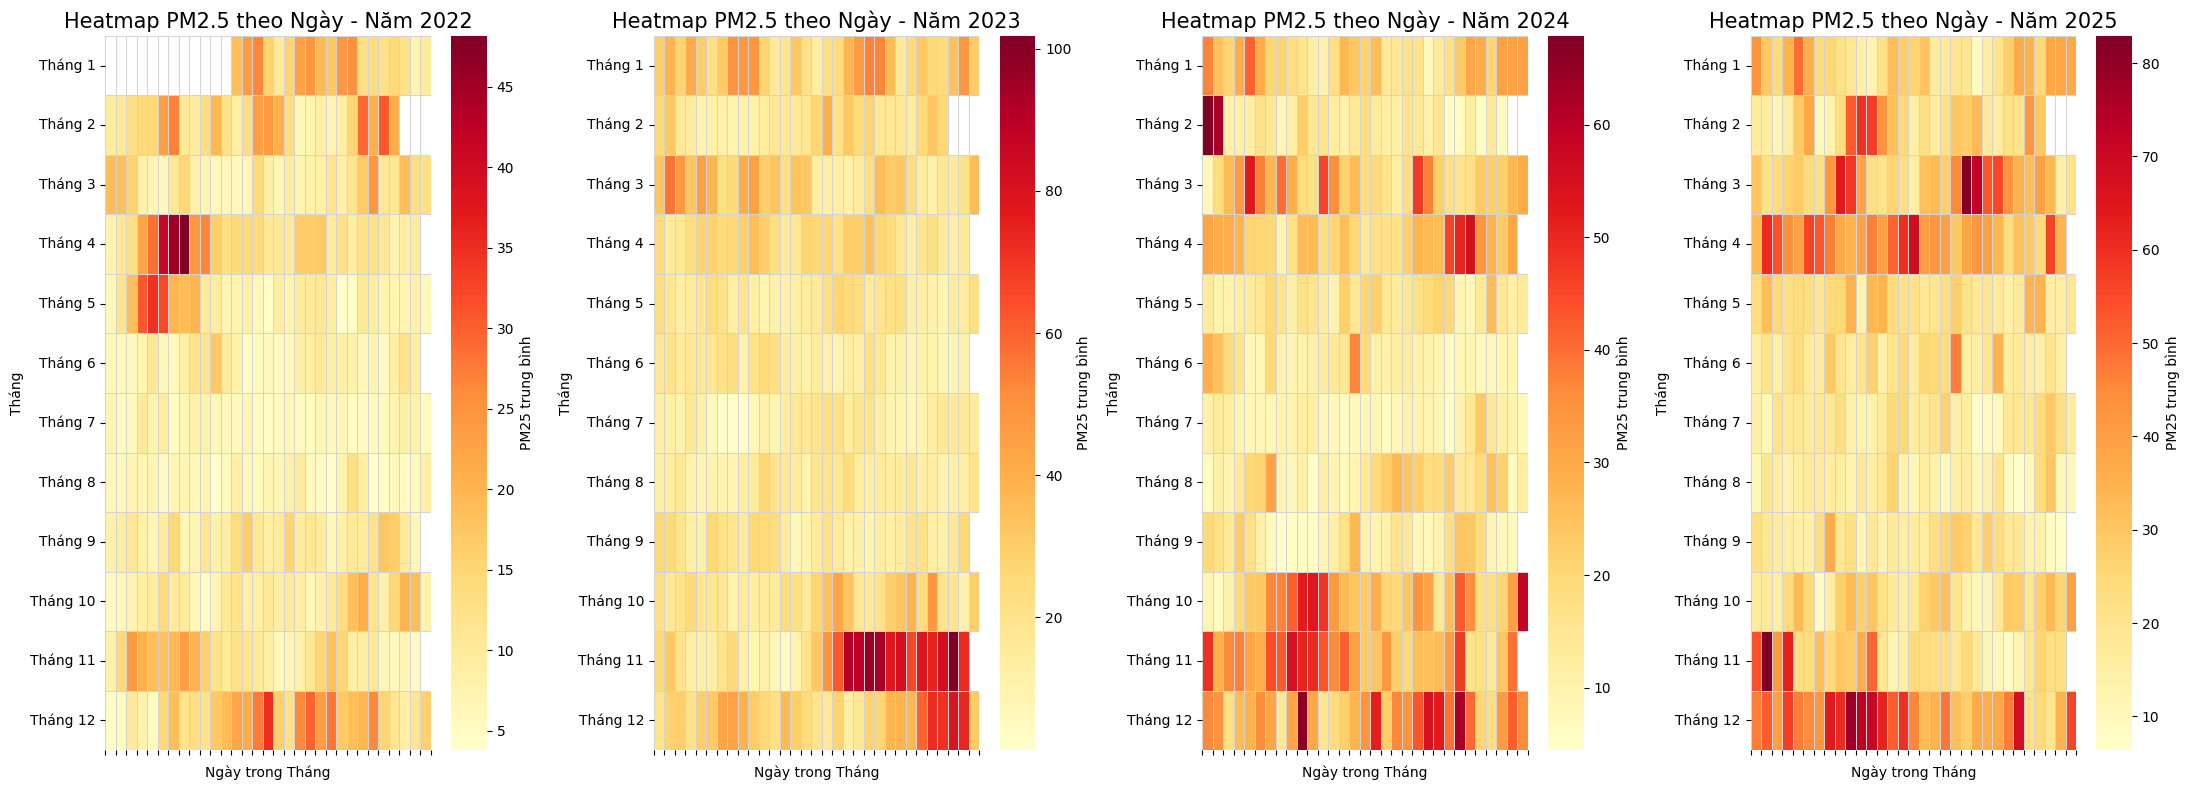

In [25]:

daily_aqi = df['PM25'].resample('D').mean()

def make_heatmap(series, year, ax):
    year_data = series.loc[str(year)]

    data = year_data.to_frame('PM25')
    data['Month'] = data.index.month
    data['Day'] = data.index.day

    heatmap_data = (
        data.pivot_table(index='Month', columns='Day', values='PM25', aggfunc='mean')
            .reindex(index=range(1, 13), columns=range(1, 32))
    )

    sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap='YlOrRd',
        linewidths=0.5,
        linecolor='lightgrey',
        cbar_kws={'label': 'PM25 trung bình'}
    )

    month_names = ['Tháng 1','Tháng 2','Tháng 3','Tháng 4','Tháng 5','Tháng 6',
                   'Tháng 7','Tháng 8','Tháng 9','Tháng 10','Tháng 11','Tháng 12']
    ax.set_yticklabels([month_names[i-1] for i in heatmap_data.index], rotation=0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel('Ngày trong Tháng')
    ax.set_ylabel('Tháng')
    ax.set_title(f'Heatmap PM2.5 theo Ngày - Năm {year}', fontsize=15)


fig, axes = plt.subplots(1, 4, figsize=(22, 8))

make_heatmap(daily_aqi, 2022, axes[0])
make_heatmap(daily_aqi, 2023, axes[1])
make_heatmap(daily_aqi, 2024, axes[2])
make_heatmap(daily_aqi, 2025, axes[3])


plt.tight_layout()
plt.show()


## 3.2 Mưa
### 3.2.1 Chuỗi thời gian lượng mưa theo giờ

In [26]:

winter_months = [11, 12, 1]
spring_months = [2, 3, 4]
summer_months = [5, 6, 7]
autumn_months = [8, 9, 10]

years = [2022, 2023, 2024, 2025]

seasons = {
    'Xuân': [2, 3, 4],
    'Hạ': [5, 6, 7],
    'Thu': [8, 9, 10],
    'Đông': [11, 12, 1]
}


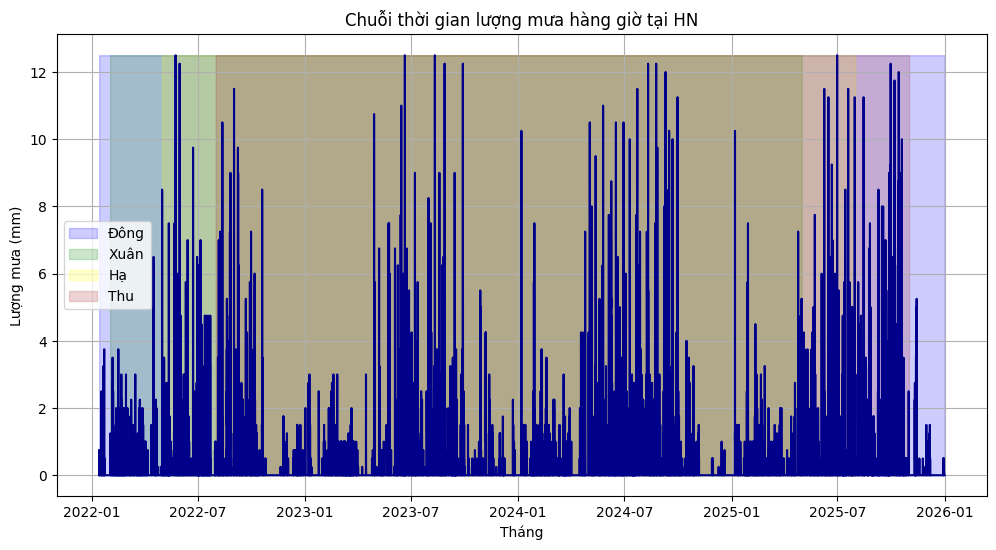

Lượng mưa hàng năm:  10542.833333343 mm


In [27]:

plt.figure(figsize=(12, 6))



plt.plot(df.index, df['Precipitation'], color='darkblue')


plt.fill_between(df.index[df.index.month.isin(winter_months)], df['Precipitation'].min(), df['Precipitation'].max(), color='blue', alpha=0.2, label='Đông')
plt.fill_between(df.index[df.index.month.isin(spring_months)], df['Precipitation'].min(), df['Precipitation'].max(), color='green', alpha=0.2, label='Xuân')
plt.fill_between(df.index[df.index.month.isin(summer_months)], df['Precipitation'].min(), df['Precipitation'].max(), color='yellow', alpha=0.2, label='Hạ')
plt.fill_between(df.index[df.index.month.isin(autumn_months)], df['Precipitation'].min(), df['Precipitation'].max(), color='brown', alpha=0.2, label='Thu')

plt.title('Chuỗi thời gian lượng mưa hàng giờ tại HN')
plt.xlabel('Tháng')
plt.ylabel('Lượng mưa (mm)')

plt.legend()
plt.grid(True)
plt.show()

annual_total_precipitation = df['Precipitation'].sum()

print("Lượng mưa hàng năm: ", annual_total_precipitation, "mm")

### 3.2.2 Tổng lượng mưa theo mùa 

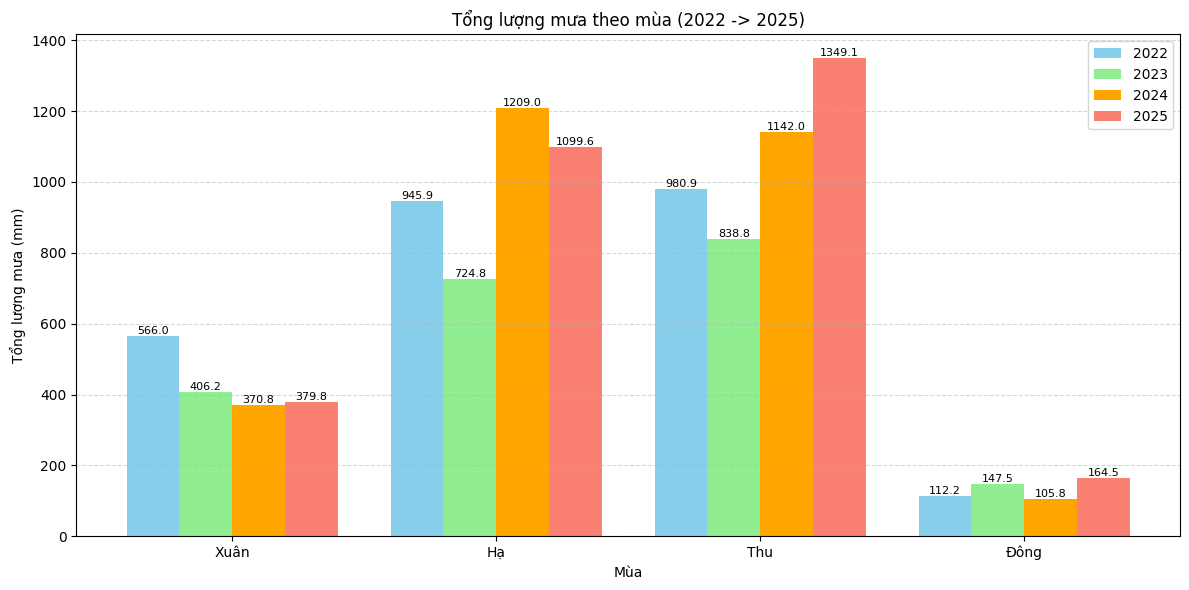

In [28]:
seasonal_precipitation_by_year = {
    year: {
        season: df.loc[(df.index.year == year) & (df.index.month.isin(months)), 'Precipitation'].sum()
        for season, months in seasons.items()
    }
    for year in years
}

seasons_list = list(seasons.keys())

values_2022 = [seasonal_precipitation_by_year[2022][s] for s in seasons_list]
values_2023 = [seasonal_precipitation_by_year[2023][s] for s in seasons_list]
values_2024 = [seasonal_precipitation_by_year[2024][s] for s in seasons_list]
values_2025 = [seasonal_precipitation_by_year[2025][s] for s in seasons_list]

x = range(len(seasons_list))
bar_width = 0.2  # Thu nhỏ lại để vừa 4 cột

plt.figure(figsize=(12, 6))
# Chia đều 4 cột với khoảng cách đều
plt.bar([i - 1.5*bar_width for i in x], values_2022, width=bar_width, color='skyblue', label='2022')
plt.bar([i - 0.5*bar_width for i in x], values_2023, width=bar_width, color='lightgreen', label='2023')
plt.bar([i + 0.5*bar_width for i in x], values_2024, width=bar_width, color='orange', label='2024')
plt.bar([i + 1.5*bar_width for i in x], values_2025, width=bar_width, color='salmon', label='2025')

plt.xticks(x, seasons_list)
plt.title('Tổng lượng mưa theo mùa (2022 -> 2025)')
plt.xlabel('Mùa')
plt.ylabel('Tổng lượng mưa (mm)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Hiển thị giá trị cho tất cả 4 năm
for i, val in enumerate(values_2022):
    plt.text(i - 1.5*bar_width, val, round(val, 1), ha='center', va='bottom', fontsize=8)
for i, val in enumerate(values_2023):
    plt.text(i - 0.5*bar_width, val, round(val, 1), ha='center', va='bottom', fontsize=8)
for i, val in enumerate(values_2024):
    plt.text(i + 0.5*bar_width, val, round(val, 1), ha='center', va='bottom', fontsize=8)
for i, val in enumerate(values_2025):
    plt.text(i + 1.5*bar_width, val, round(val, 1), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

**-> KẾT LUẬN:** Khi xem xét biểu đồ và dữ liệu lượng mưa theo mùa, rõ ràng là mùa hè và mùa thu có lượng mưa lớn nhất, trong đó mùa thu là mùa mưa nhiều nhất. Ngược lại, mùa xuân thường xuyên có mưa phùn, trong khi mùa đông được ghi nhận là mùa khô nhất.

## 3.3 Áp suất
### Chuỗi thời gian lượng áp suất theo giờ

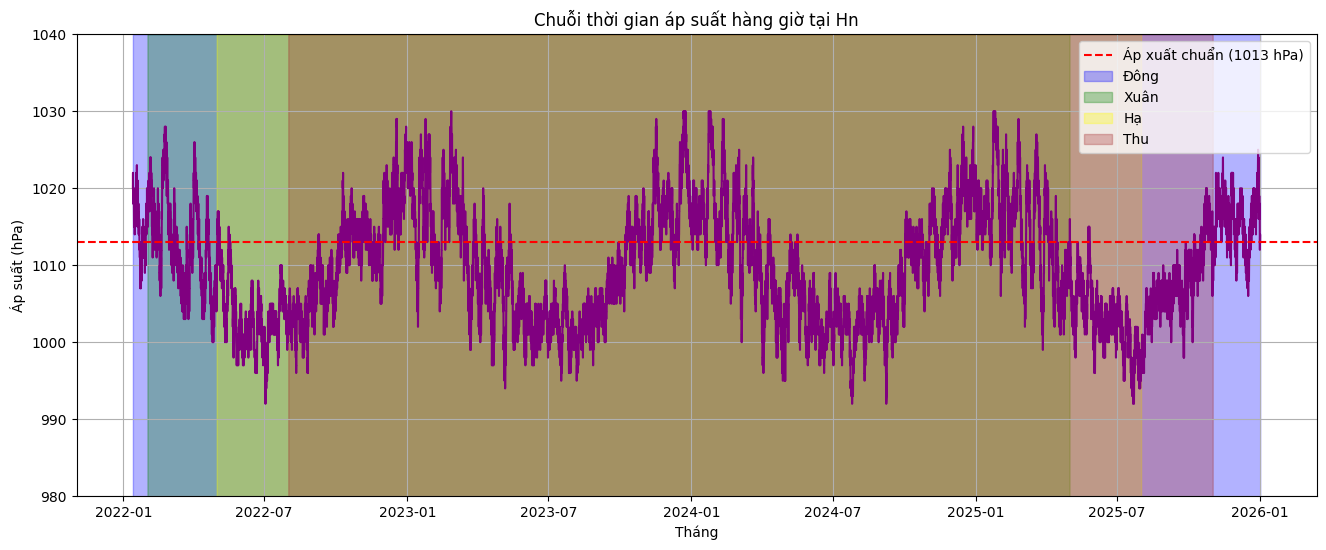

In [29]:


plt.figure(figsize=(16, 6))  
plt.plot(df.index, df['Pressure'], color='purple')  

plt.axhline(y=1013, color='red', linestyle='--', label='Áp xuất chuẩn (1013 hPa)')


plt.fill_between(df.index[df.index.month.isin(winter_months)], 980, 1040, color='blue', alpha=0.3, label='Đông')
plt.fill_between(df.index[df.index.month.isin(spring_months)], 980, 1040, color='green', alpha=0.3, label='Xuân')
plt.fill_between(df.index[df.index.month.isin(summer_months)], 980, 1040, color='yellow', alpha=0.3, label='Hạ')
plt.fill_between(df.index[df.index.month.isin(autumn_months)], 980, 1040, color='brown', alpha=0.3, label='Thu')

plt.title('Chuỗi thời gian áp suất hàng giờ tại Hn') 
plt.xlabel('Tháng')  
plt.ylabel('Áp suất (hPa)')  
plt.ylim(980, 1040) 
plt.grid(True)  
plt.legend() 
plt.show()  

**-> KẾT LUẬN:** 
- Mùa Đông: áp suất cao hơn mức chuẩn, dao động quanh 1020–1030 hPa → thời tiết lạnh, khô, ổn định → đặc trưng mùa Đông miền Bắc.
- Mùa Xuân : áp suất giảm nhẹ, nhiều biến động → thời tiết ẩm, mưa phùn, gió mùa.
- Mùa Hạ: áp suất thấp nhất năm (~995–1005 hPa) → thời kỳ nóng ẩm, mưa nhiều, dông bão.
- Mùa Thu: áp suất tăng trở lại, thời tiết mát, khô, ít mưa.

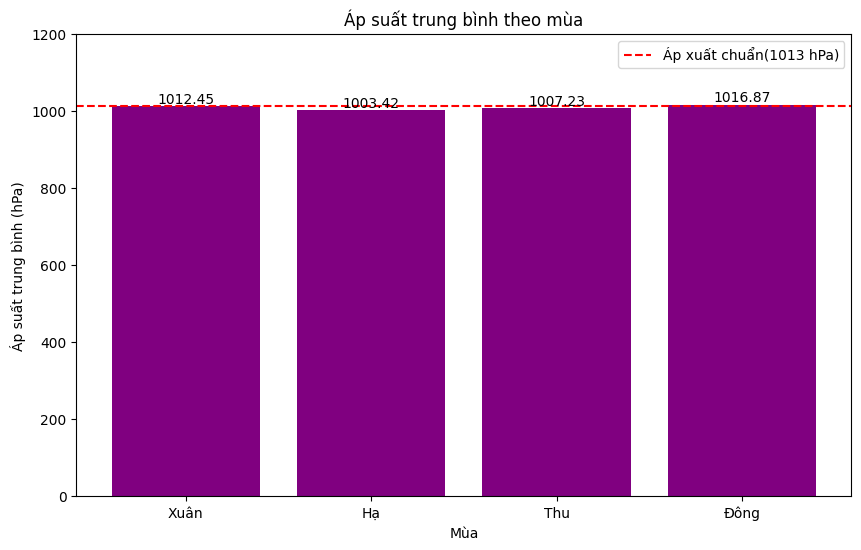

In [30]:
seasonal_humid = {}
for season, months in seasons.items():
    seasonal_humid[season] = df.loc[df.index.month.isin(months), 'Pressure'].mean()


plt.figure(figsize=(10, 6))
bars = plt.bar(seasonal_humid.keys(), seasonal_humid.values(), color='purple')
plt.axhline(y=1013, color='red', linestyle='--', label='Áp xuất chuẩn(1013 hPa)')
plt.title('Áp suất trung bình theo mùa')
plt.xlabel('Mùa')
plt.ylabel('Áp suất trung bình (hPa)')
plt.ylim(0, 1200)  

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2),
             ha='center', va='bottom')
plt.legend()
plt.show()


Trong các biểu đồ được mô tả ở trên, mức áp suất tại Hà Nội trong mùa hè và mùa thu giảm đáng kể xuống dưới mức chuẩn. Theo [National Geographic](https://education.nationalgeographic.org/resource/atmospheric-pressure/), những sai lệch như vậy thường đi kèm với các hệ thống áp thấp, thường báo hiệu mây mù, gió mạnh và lượng mưa. Hiện tượng này cho thấy lượng mưa lớn được quan sát thấy trong các mùa này. Ngược lại, mùa đông có mức áp suất khí quyển cao nhất, dẫn đến không khí tù đọng. Theo giải thích của [University Corporation for Atmospheric Research](https://scied.ucar.edu/learning-zone/air-quality/how-weather-affects-air-quality), không khí tù đọng này có thể giữ lại các chất ô nhiễm từ khí thải xe cộ và nhà máy trong khí quyển thành phố, dẫn đến nồng độ PM2.5 tăng cao trong mùa. Trong khi đó, các số liệu áp suất vào mùa xuân dao động quanh mức chuẩn, cho thấy điều kiện khí quyển tương đối ổn định trong thời gian đó.

## 3.4 Độ ẩm
### Chuỗi thời gian độ ẩm theo giờ

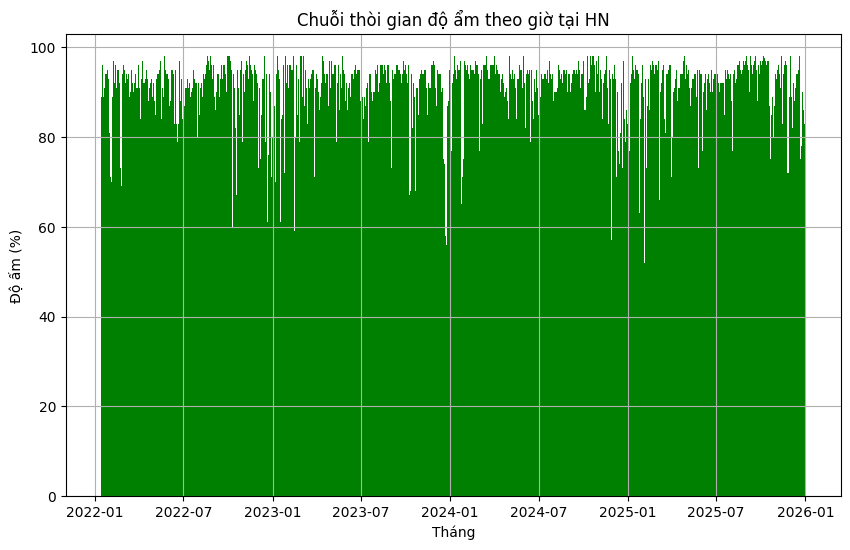

Độ ẩm trung bình hàng năm 78.21 %


In [31]:

plt.figure(figsize=(10, 6))  
plt.bar(df.index, df['Relative Humidity'], color='green', linestyle='-')  
plt.title('Chuỗi thòi gian độ ẩm theo giờ tại HN')  
plt.xlabel('Tháng')  
plt.ylabel('Độ ấm (%)')  
plt.grid(True) 
plt.show()  


average_annual_rh = df["Relative Humidity"].mean()

print("Độ ẩm trung bình hàng năm", round(average_annual_rh, 2), '%')

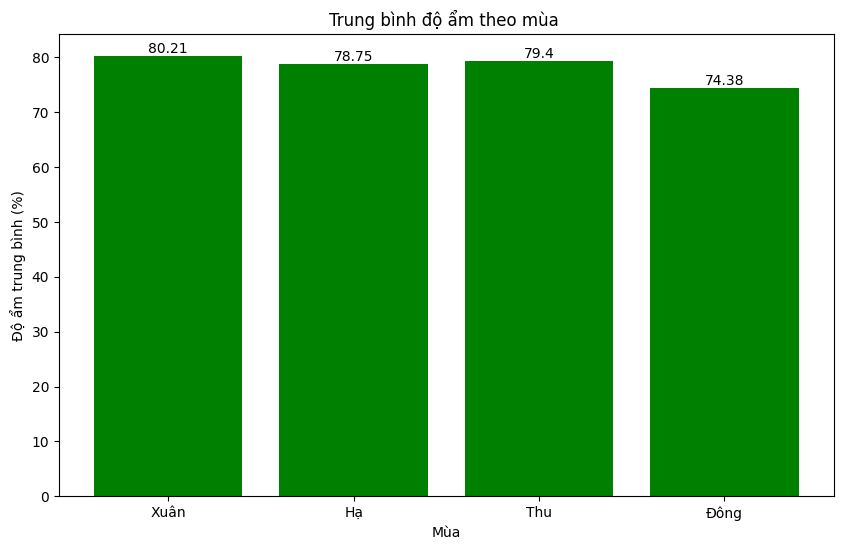

In [32]:
seasonal_humid = {}
for season, months in seasons.items():
    seasonal_humid[season] = df.loc[df.index.month.isin(months), 'Relative Humidity'].mean()


plt.figure(figsize=(10, 6))
bars = plt.bar(seasonal_humid.keys(), seasonal_humid.values(), color='green')
plt.title('Trung bình độ ẩm theo mùa ')
plt.xlabel('Mùa')
plt.ylabel('Độ ẩm trung bình (%)')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2),
             ha='center', va='bottom')

plt.show()

Độ ẩm trung bình năm đạt khoảng 77.97%, là mức cao ổn định, cho thấy Hà Nội có môi trường ẩm quanh năm.
Các giai đoạn dao động mạnh thường trùng với các thời điểm chuyển mùa (đặc biệt từ Xuân → Hạ và Thu → Đông), khi nhiệt độ và lượng mưa thay đổi nhanh chóng.
Hà Nội có độ ẩm cao quanh năm, ít khi dưới 70%, điều này lý giải tại sao mùa hè nóng thường đi kèm cảm giác oi bức, còn mùa đông lại khô và hanh.

Độ ẩm cao nhất vào mùa Xuân → dễ gây ra mưa phùn, ẩm mốc, ảnh hưởng đến sức khỏe và sinh hoạt.

Độ ẩm thấp nhất vào mùa Đông → tạo nên không khí lạnh khô, làm da khô, nứt nẻ, bụi mịn dễ phát tán.

## 3.5 Nhiệt độ


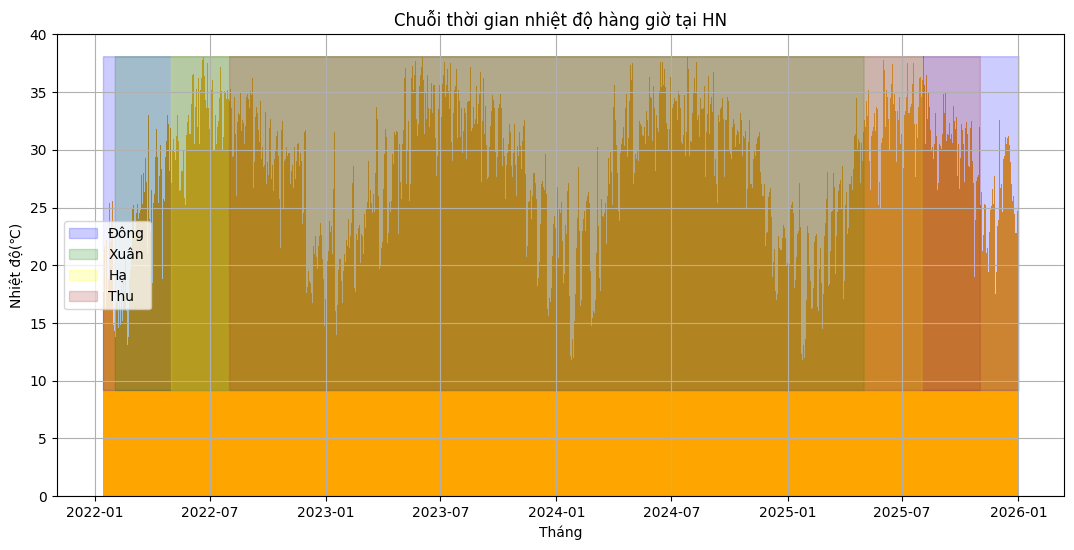

Nhiệt độ trung bình : 25.05 ℃ 



In [33]:

plt.figure(figsize=(13, 6))


plt.bar(df.index, df['Temperature'], color='orange', linestyle='-')


plt.fill_between(df.index[df.index.month.isin(winter_months)], df['Temperature'].min(), df['Temperature'].max(), color='blue', alpha=0.2, label='Đông')
plt.fill_between(df.index[df.index.month.isin(spring_months)], df['Temperature'].min(), df['Temperature'].max(), color='green', alpha=0.2, label='Xuân')
plt.fill_between(df.index[df.index.month.isin(summer_months)], df['Temperature'].min(), df['Temperature'].max(), color='yellow', alpha=0.2, label='Hạ')
plt.fill_between(df.index[df.index.month.isin(autumn_months)], df['Temperature'].min(), df['Temperature'].max(), color='brown', alpha=0.2, label='Thu')


plt.title('Chuỗi thời gian nhiệt độ hàng giờ tại HN')
plt.xlabel('Tháng')
plt.ylabel('Nhiệt độ(℃)')


plt.legend()

plt.grid(True)
plt.show()

average_annual_temperature = df['Temperature'].mean()
print("Nhiệt độ trung bình :", round(average_annual_temperature, 2), "℃ \n")

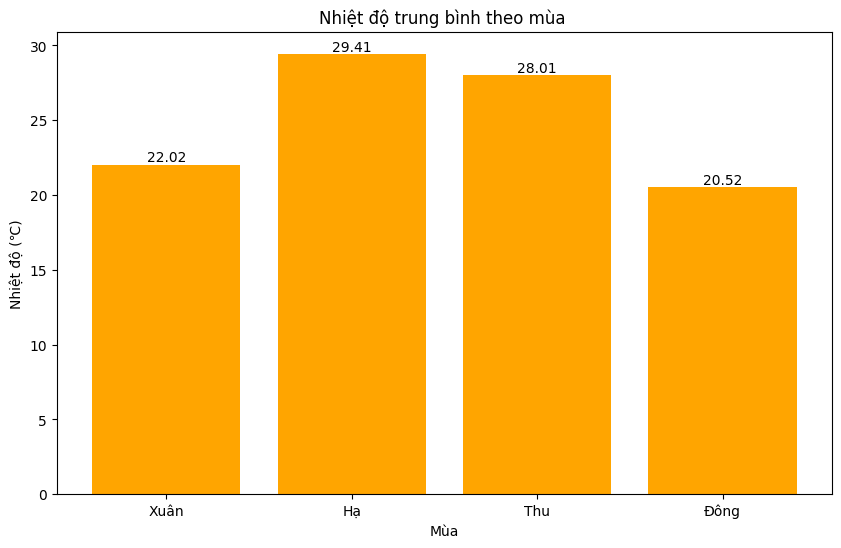

In [34]:
seasonal_temp = {}
for season, months in seasons.items():
    seasonal_temp[season] = df.loc[df.index.month.isin(months), 'Temperature'].mean()


plt.figure(figsize=(10, 6))
bars = plt.bar(seasonal_temp.keys(), seasonal_temp.values(), color='orange')
plt.title('Nhiệt độ trung bình theo mùa ')
plt.xlabel('Mùa')
plt.ylabel('Nhiệt độ (℃)')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2),
             ha='center', va='bottom')

plt.show()

## 3.6 Tốc độ gió


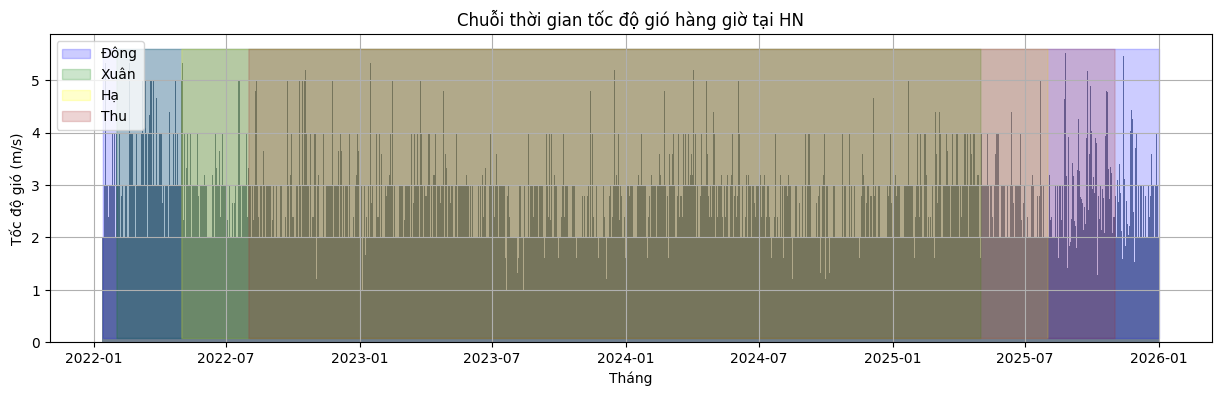

Tốc độ gió trung bình: 1.76 m/s



In [35]:
plt.figure(figsize=(15, 4))

plt.bar(df.index, df['Wind Speed'], color='slategray', linestyle='-')


plt.fill_between(df.index[df.index.month.isin(winter_months)], df['Wind Speed'].min(), df['Wind Speed'].max(), color='blue', alpha=0.2, label='Đông')
plt.fill_between(df.index[df.index.month.isin(spring_months)], df['Wind Speed'].min(), df['Wind Speed'].max(), color='green', alpha=0.2, label='Xuân')
plt.fill_between(df.index[df.index.month.isin(summer_months)], df['Wind Speed'].min(), df['Wind Speed'].max(), color='yellow', alpha=0.2, label='Hạ')
plt.fill_between(df.index[df.index.month.isin(autumn_months)], df['Wind Speed'].min(), df['Wind Speed'].max(), color='brown', alpha=0.2, label='Thu')


plt.title('Chuỗi thời gian tốc độ gió hàng giờ tại HN')
plt.xlabel('Tháng')
plt.ylabel('Tốc độ gió (m/s)')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()


average_annual_wind_speed = df['Wind Speed'].mean()


print("Tốc độ gió trung bình:", round(average_annual_wind_speed, 2), "m/s\n")

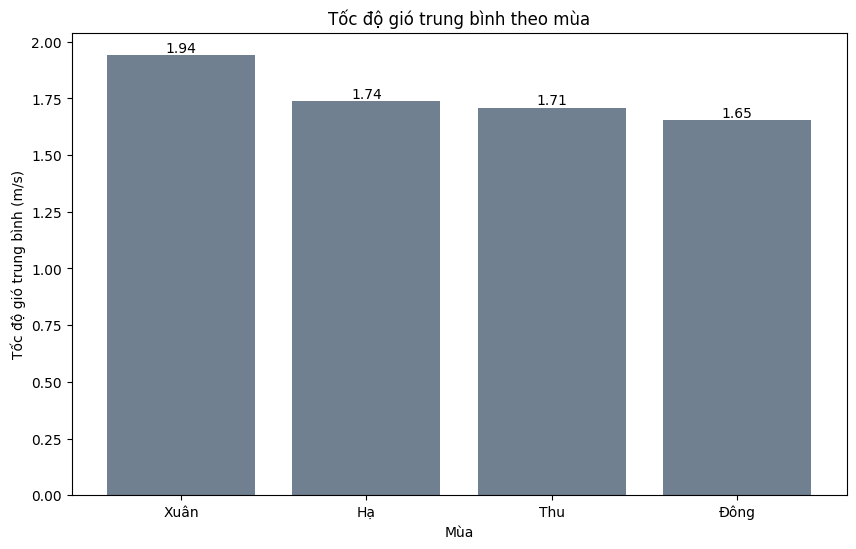

In [36]:
seasonal_wind_speed = {}
for season, months in seasons.items():
    seasonal_wind_speed[season] = df.loc[df.index.month.isin(months), 'Wind Speed'].mean()


plt.figure(figsize=(10, 6))
bars = plt.bar(seasonal_wind_speed.keys(), seasonal_wind_speed.values(), color='slategray')
plt.title('Tốc độ gió trung bình theo mùa')
plt.xlabel('Mùa')
plt.ylabel('Tốc độ gió trung bình (m/s)')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2),
             ha='center', va='bottom')

plt.show()

Nhìn chung, Hà Nội có tốc độ gió tương đối thấp, với tốc độ gió trung bình hàng năm là 1,62 m/s. Trong 2 năm mùa xuân ghi nhận tốc độ gió trung bình cao nhất, có thể do ảnh hưởng của gió mùa Đông Bắc. Mùa hè tiếp theo có tốc độ gió trung bình cao thứ hai, có thể do mưa rào thường xuyên. Điều thú vị là mùa thu và mùa đông có tốc độ gió tương tự nhau.

# IV. Ảnh hưởng của thời tiết đến chất lượng không khí 
Báo [Kinh tế và Dự báo](https://kinhtevadubao.vn/chi-so-chat-luong-khong-khi-la-gi-anh-huong-cua-o-nhiem-khong-khi-den-suc-khoe-con-nguoi-30928.html?utm_source=chatgpt.com) cho biết chỉ số AQI thường được tính toán dựa trên mức độ ô nhiễm của một số chất khí như PM2.5 (bụi mịn), PM10, ozone (O3), NO2 (nitrogen dioxide), SO2 (sulfur dioxide), và CO (carbon monoxide)

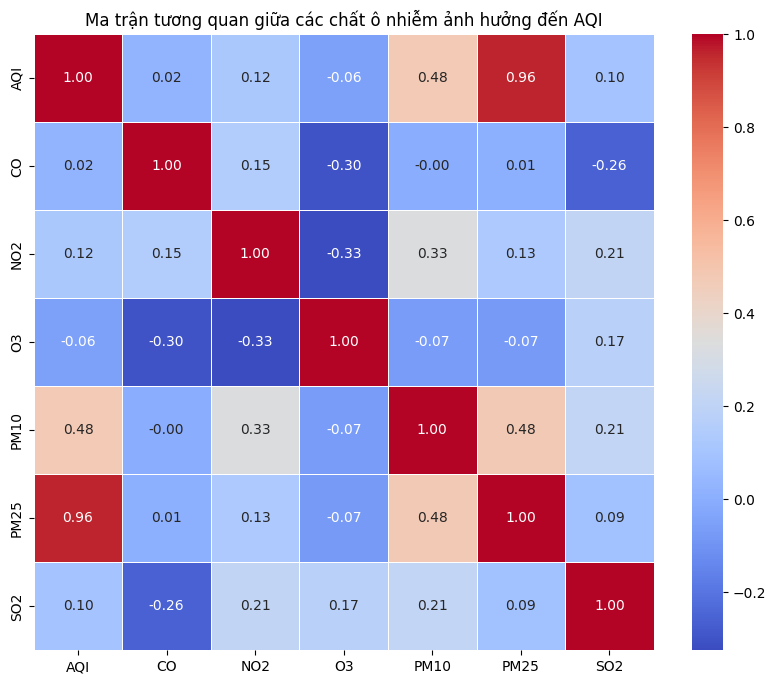

In [37]:
corr_columns = ['AQI', 'CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']

correlation_matrix = df[corr_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Ma trận tương quan giữa các chất ô nhiễm ảnh hưởng đến AQI')
plt.show()


**-> KẾT LUẬN:**
- Phân tích ma trận tương quan cho thấy PM2.5 là yếu tố quyết định chính đối với chỉ số AQI tại Hà Nội, có hệ số tương quan 0.95 — mức cực cao.
- Ngoài ra, PM10 và NO2 cũng góp phần làm tăng mức độ ô nhiễm, nhưng yếu hơn đáng kể.
- Các khí khác như CO, SO2, O3 có ảnh hưởng rất nhỏ
- Theo [VnExpress](https://vnexpress.net/chat-luong-khong-khi-ha-noi-suy-giam-dien-rong-4718820.html), cũng nhắc đến PM2.5 (chiếm 66.3%) là nguyên nhân chính dẫn đến chất lượng ko khí bị suy giảm 
-> PM2.5 đc chọn lm biến số đo lường chất lượng ko khí 

## 4.1 Mưa

### 4.1.1 Giờ mưa

In [38]:
accumulated_hours_of_rain = 0
accumulated_hours_list = []

for precipitation in df['Precipitation']:
    if precipitation > 0:
        accumulated_hours_of_rain += 1
    else:
        accumulated_hours_of_rain = 0
        
    accumulated_hours_list.append(accumulated_hours_of_rain)
    
df['Accumulated Hours of Rain'] = accumulated_hours_list
df.head(3)
    


,index,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed,HolidayName,IsHoliday,Accumulated Hours of Rain
Local Time,,,,,,,,,,,,,,,,,,
2022-01-13 07:00:00,0,61.0,353.1,10.0,84.0,98.0,17.08,52.0,100,0.0,1020.0,95.0,15.5,0.6,2.00,Ngày thường,False,0
2022-01-13 08:00:00,1,61.0,343.5,9.0,87.3,95.7,16.75,48.7,91,0.0,1021.0,94.0,15.4,0.7,2.33,Ngày thường,False,0
2022-01-13 09:00:00,2,60.0,334.0,8.0,90.7,93.3,16.42,45.3,83,0.5,1022.0,93.0,15.3,1.0,2.66,Ngày thường,False,1


In [39]:
df['Accumulated Hours of Rain'].describe()

count    34759.00000
mean         1.28571
std          4.05738
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max         56.00000
Name: Accumulated Hours of Rain, dtype: float64

### 4.1.2 Mối quan hệ giữa giờ mưa và nồng độ PM2.5

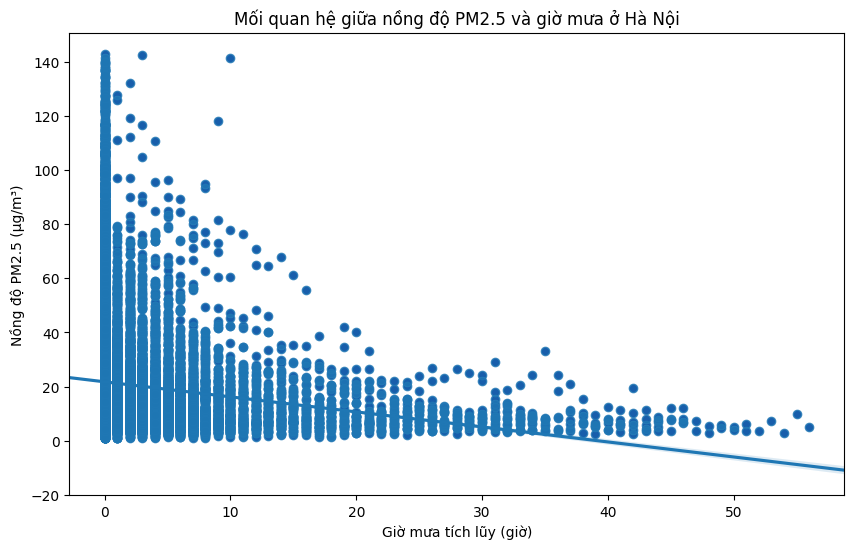

Hệ số tương quan: -0.13


In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Accumulated Hours of Rain', y='PM25', color='darkblue')

sns.regplot(data=df, x='Accumulated Hours of Rain', y='PM25', truncate=False)
correlation_coefficient = df['Accumulated Hours of Rain'].corr(df['PM25'])


plt.title('Mối quan hệ giữa nồng độ PM2.5 và giờ mưa ở Hà Nội')
plt.xlabel('Giờ mưa tích lũy (giờ)')
plt.ylabel('Nồng độ PM2.5 (μg/m³)')

plt.show()


print(f"Hệ số tương quan: {correlation_coefficient:.2f}")

### 4.1.3 Mối quan hệ giữa lượng mưa và nồng độ PM2.5

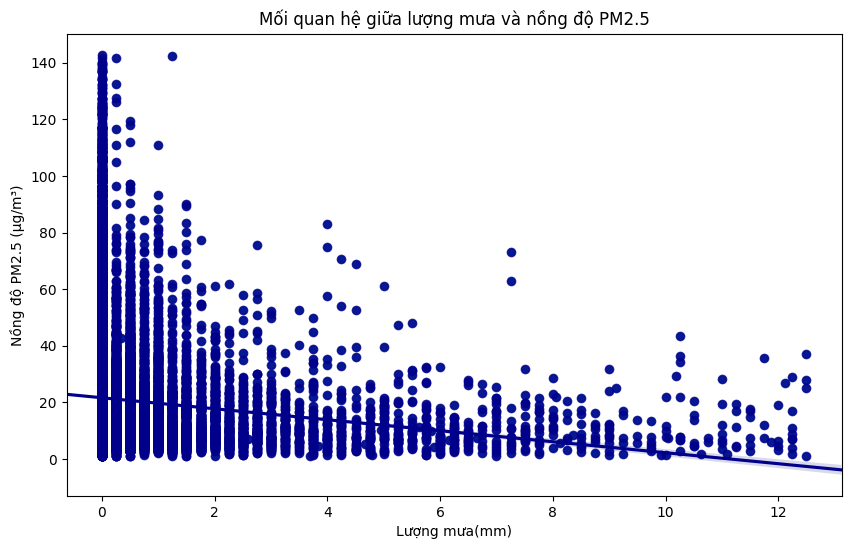

Hệ số tương quan: -0.11


In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Precipitation', y='PM25')


sns.regplot(data=df, x='Precipitation', y='PM25', truncate= False, color='darkblue')

correlation_coefficient = df['Precipitation'].corr(df['PM25'])

plt.title('Mối quan hệ giữa lượng mưa và nồng độ PM2.5')
plt.xlabel('Lượng mưa(mm)')
plt.ylabel('Nồng độ PM2.5 (μg/m³)')

plt.show()

print(f"Hệ số tương quan: {correlation_coefficient:.2f}")

## 4.2 Ảnh hưởng của áp suất đến PM2.5

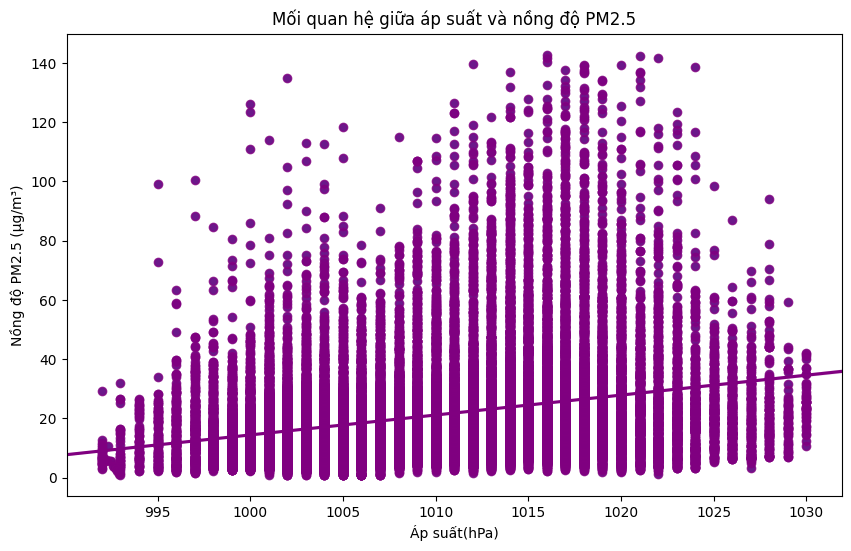

Hệ số tương quan: 0.28


In [42]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Pressure', y='PM25')
sns.regplot(data=df, x='Pressure', y='PM25', truncate= False, color='purple')


correlation_coefficient = df['Pressure'].corr(df['PM25'])


plt.title('Mối quan hệ giữa áp suất và nồng độ PM2.5')
plt.xlabel('Áp suất(hPa)')
plt.ylabel('Nồng độ PM2.5 (μg/m³)')

plt.show()

print(f"Hệ số tương quan: {correlation_coefficient:.2f}")

## 4.3 Ảnh hưởng của độ ẩm đến PM2.5

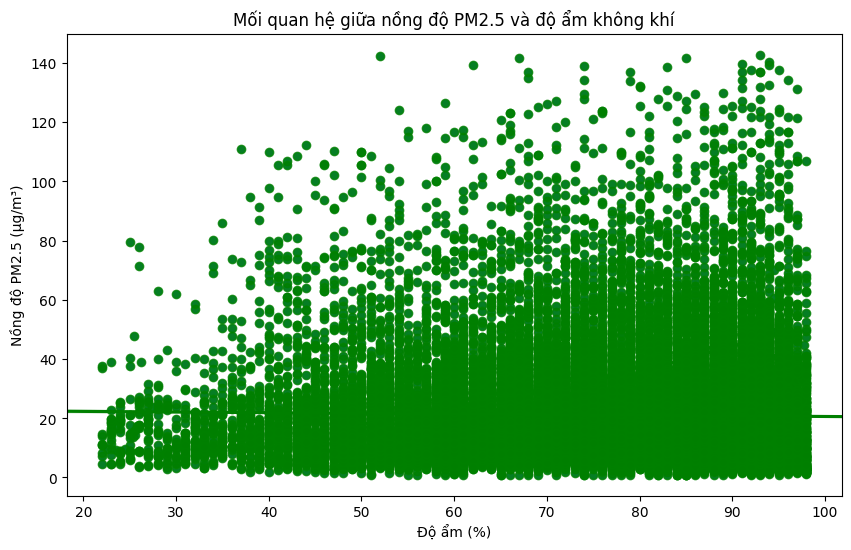

Hệ số tương quan: -0.02


In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Relative Humidity', y='PM25')

sns.regplot(data=df, x='Relative Humidity', y='PM25', truncate=False, color='green')


correlation_coefficient = df['Relative Humidity'].corr(df['PM25'])

plt.title('Mối quan hệ giữa nồng độ PM2.5 và độ ẩm không khí')
plt.xlabel('Độ ẩm (%)')
plt.ylabel('Nồng độ PM2.5 (μg/m³)')

plt.show()


print(f"Hệ số tương quan: {correlation_coefficient:.2f}")

## 4.4 Ảnh hưởng của nhiệt độ đến PM2.5

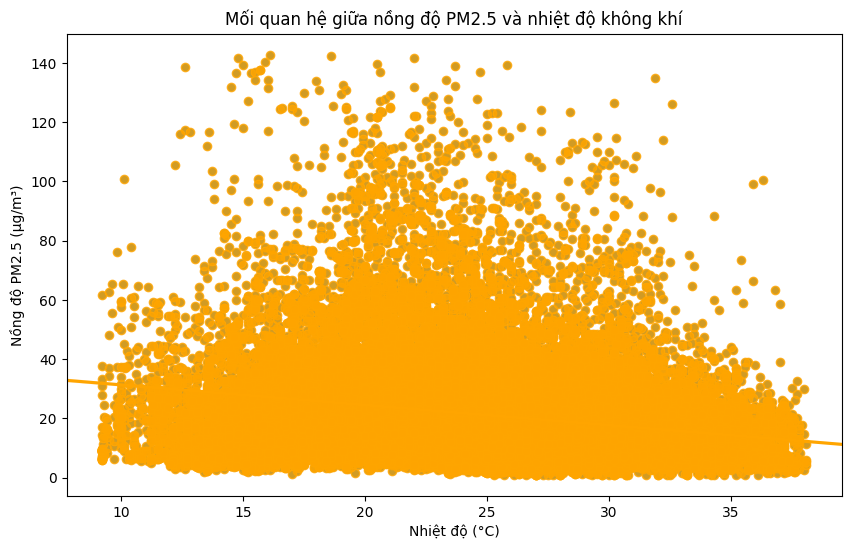

Hệ số tương quan: -0.22


In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Temperature', y='PM25')
sns.regplot(data=df, x='Temperature', y='PM25', truncate=False, color='orange')

correlation_coefficient = df['Temperature'].corr(df['PM25'])
plt.title('Mối quan hệ giữa nồng độ PM2.5 và nhiệt độ không khí')
plt.xlabel('Nhiệt độ (°C)')
plt.ylabel('Nồng độ PM2.5 (μg/m³)')

plt.show()

print(f"Hệ số tương quan: {correlation_coefficient:.2f}")

## 4.5 Ảnh hưởng của tốc độ gió đến PM2.5

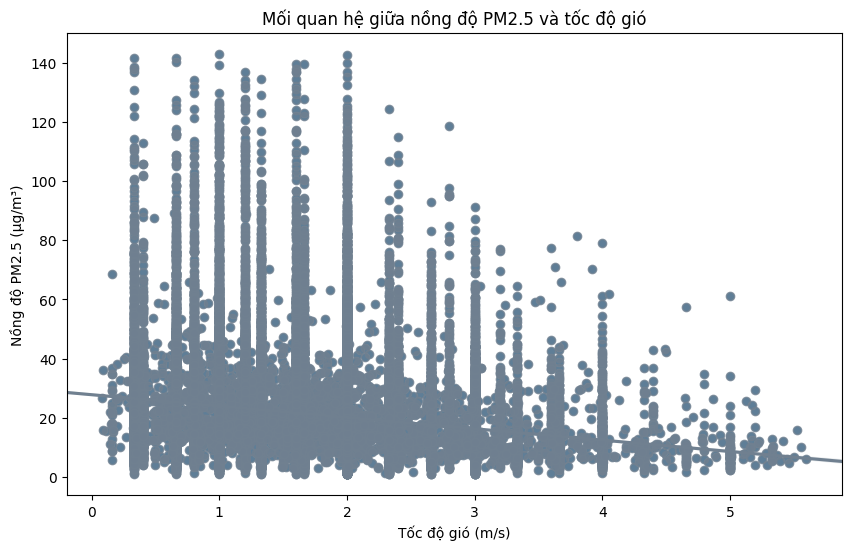

Hệ số tương quan: -0.19


In [45]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Wind Speed', y='PM25')
sns.regplot(data=df, x='Wind Speed', y='PM25', truncate=False, color='slategray')
correlation_coefficient = df['Wind Speed'].corr(df['PM25'])


plt.title('Mối quan hệ giữa nồng độ PM2.5 và tốc độ gió')
plt.xlabel('Tốc độ gió (m/s)')
plt.ylabel('Nồng độ PM2.5 (μg/m³)')

plt.show()


print(f"Hệ số tương quan: {correlation_coefficient:.2f}")

In [47]:
# # Tạo bản dữ liệu đã xử lý cuối cùng
df = df.reset_index()
df_clean = df.copy()
df_clean = df_clean.drop(columns=['AQI'])
# Xuất ra CSV
df_clean.to_csv('data2225_clean.csv', index=False)

print("Đã lưu dữ liệu sạch vào 'data2225_clean.csv' với kích thước:", df_clean.shape)

Đã lưu dữ liệu sạch vào 'data2225_clean.csv' với kích thước: (34759, 18)


## V. Tổng kết EDA

Dựa trên toàn bộ quá trình làm sạch và trực quan hóa, có thể rút ra một số kết luận chính sau:

- **Về dữ liệu và tiền xử lý**:
  - Dữ liệu đo chất lượng không khí theo giờ tại Hà Nội giai đoạn 2022–2025 có kích thước lớn, liên tục và bao phủ đầy đủ các chất ô nhiễm (AQI, PM2.5, PM10, CO, NO2, O3, SO2) cùng các yếu tố khí tượng quan trọng.
  - Dữ liệu ban đầu tồn tại một số giá trị thiếu và ngoại lệ; sau khi lọc outlier theo percentile 0.1%–99.9% và nội suy theo thời gian, ta thu được một bộ dữ liệu sạch, không còn `NaN`, phù hợp cho trực quan hóa và mô hình hóa.

- **Về hành vi của PM2.5**:
  - Nồng độ PM2.5 có **tính mùa vụ rõ rệt**: cao nhất vào mùa Đông – Xuân, thấp nhất vào mùa Hè, và tăng dần trở lại vào mùa Thu.
  - Theo **giờ trong ngày**, PM2.5 có xu hướng cao vào giờ cao điểm sáng (6–8h) và chiều tối (18–21h), phản ánh ảnh hưởng của giao thông, sinh hoạt và điều kiện khí tượng ban đêm.
  - So sánh ngày thường và các dịp lễ/nghỉ dài cho thấy PM2.5 có sự khác biệt nhất định, gợi ý vai trò của hoạt động con người.

- **Về điều kiện thời tiết**:
  - Lượng mưa tập trung chủ yếu vào mùa Hè và một phần mùa Thu; các mùa mưa nhiều đi kèm chất lượng không khí tốt hơn (PM2.5 giảm do được “rửa trôi” và khuếch tán tốt hơn).
  - Áp suất, độ ẩm, nhiệt độ và tốc độ gió đều có **mẫu hình theo mùa**: áp suất cao, gió yếu và độ ẩm dao động mạnh vào mùa Đông tạo điều kiện bất lợi cho khuếch tán chất ô nhiễm; trong khi mùa Hè mưa nhiều, gió mạnh và lớp biên khí quyển cao giúp không khí “thông thoáng” hơn.

- **Về mối quan hệ giữa PM2.5 và các biến khác**:
  - Ma trận tương quan cho thấy **AQI phụ thuộc rất mạnh vào PM2.5**, đồng thời chịu ảnh hưởng bổ sung từ PM10 và NO2.
  - Các scatter plot cho thấy mưa và gió có xu hướng **giảm PM2.5** khi cường độ đủ lớn, trong khi điều kiện áp suất cao, độ ẩm cao và nhiệt độ thấp vào mùa lạnh thường đi kèm PM2.5 cao hơn.

Nhìn chung, bộ dữ liệu sau khi làm sạch đã phản ánh rõ **chu kỳ mùa vụ, biến động theo giờ và ảnh hưởng của thời tiết** lên PM2.5 tại Hà Nội. Notebook này có thể được dùng như bước tiền xử lý và phân tích nền tảng trước khi xây dựng các mô hình dự báo (ví dụ LSTM hoặc GRU) trong notebook tiếp theo.